In [14]:
# Import Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import gmaps

In [15]:
# Import CSV with top zip codes
top_zips_df = pd.read_csv('../Resources/25 Final Zip Codes.csv')

In [16]:
# Create list of top 25 zips from the csv file
zip_codes = top_zips_df["zip"]

In [4]:
# Create initial lists for everything we are pulling from the data frame
listing_type = []
addresses = []
prices = []
zips = []
lats = []
lons = []
sqft = []
beds = []
baths = []

In [5]:
# Set up url to call to Realtors "sold houses" API
url = "https://realtor.p.rapidapi.com/properties/list-sold"

# Set up initial parameters
querystring = {"sort":"relevance",
               "offset":"0",
               "limit":"200"}

# Set up headers to call through Rapid API
headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': "aaf97ab322msh634818fa34ec594p1b03e3jsnaf892e7d4ed3"
    }

# Begin for loop, looking through the zip codes in the Top 25 Zip File
for zip in zip_codes:
    
    counter=-1

    # Update parameters with the current zip code
    querystring['postal_code'] = zip
    
    # Was having issues with various zips not pulling, put in exception handling to keep it moving
    try:
        response = requests.request("GET", url, headers=headers, params=querystring).json()
        sold_listings = response["listings"]
    except:
        continue
    
    # Once we've pulled the json for the current zip, we extract values from the json and add to our initial lists.
    for listing in sold_listings:
        try: 
            counter = counter+1
            address = sold_listings[counter]["address"]
            price = int(sold_listings[counter]["price_raw"])
            lat = sold_listings[counter]["lat"]
            lon = sold_listings[counter]["lon"]
            zip = int(address[-5:])
            sft = sold_listings[counter]["sqft_raw"]
            bed = sold_listings[counter]["beds"]
            bath = sold_listings[counter]["baths"]
            listing_type.append("Sold")
            addresses.append(address)
            prices.append(price)
            lats.append(lat)
            lons.append(lon)
            zips.append(zip)
            sqft.append(sft)
            beds.append(bed)
            baths.append(bath)
        except (KeyError, IndexError):
            listing_type.append(None)
            addresses.append(None)
            prices.append(None)
            lats.append(None)
            lons.append(None)
            zips.append(None)
            sqft.append(None)
            beds.append(None)
            baths.append(None)

In [6]:
# Call to houses for sale API - Same format as above!
url = "https://realtor.p.rapidapi.com/properties/list-for-sale"

querystring = {"sort":"relevance",
               "offset":"0",
               "limit":"200"}

headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': "aaf97ab322msh634818fa34ec594p1b03e3jsnaf892e7d4ed3"
    }

for zip in zip_codes:
    
    counter=-1

    # update address key value
    querystring['postal_code'] = zip
    
    try:
        response = requests.request("GET", url, headers=headers, params=querystring).json()
        for_sale_listings = response["listings"]
    except:
        continue
    
    
    for listing in for_sale_listings:
        try: 
            counter = counter+1
            address = for_sale_listings[counter]["address"]
            price = int(for_sale_listings[counter]["price_raw"])
            lat = for_sale_listings[counter]["lat"]
            lon = for_sale_listings[counter]["lon"]
            zip = int(address[-5:])
            sft = for_sale_listings[counter]["sqft_raw"]
            bed = for_sale_listings[counter]["beds"]
            bath = for_sale_listings[counter]["baths"]
            listing_type.append("For Sale")
            addresses.append(address)
            prices.append(price)
            lats.append(lat)
            lons.append(lon)
            zips.append(zip)
            sqft.append(sft)
            beds.append(bed)
            baths.append(bath)
        except (KeyError, IndexError):
            listing_type.append(None)
            addresses.append(None)
            prices.append(None)
            lats.append(None)
            lons.append(None)
            zips.append(None)
            sqft.append(None)
            beds.append(None)
            baths.append(None)

In [7]:
# Create a data frame to hold results from the 2 API pulls above, create Price per Square Foot column.
combined_df = pd.DataFrame()
combined_df["Listing Type"]= listing_type
combined_df["Address"]=addresses
combined_df["Prices"]=prices
combined_df["Lat"]=lats
combined_df["Lon"]=lons
combined_df["Zip"]=zips
combined_df["Sq Ft"]=sqft
combined_df["Beds"]=beds
combined_df["Baths"]=baths
combined_df["Price per Square Foot"]=""

In [8]:
# Reformat Sq Ft as a float, remove listing with 0 sq ft (new builds, land, etc.), calculate price per square foot.

combined_df["Sq Ft"] = combined_df["Sq Ft"].astype(float)
combined_df["Prices"] = combined_df["Prices"].astype(float)

combined_df = combined_df.loc[(combined_df["Sq Ft"]>0),:]
combined_df["Price per Square Foot"] = combined_df["Prices"]/combined_df["Sq Ft"]

combined_df.head()

Listing Type                                            Address    Prices  \
0         Sold  10350 W 55th Ln Unit 202 in Oberon West - Arva...  350000.0   
1         Sold                    5563 Newland Way, Arvada, 80002  420000.0   
2         Sold  5747 Falk Ct in Arvada Plaza Area - Arvada,CO,...  445500.0   
3         Sold  4890 Estes St in Pleasant Valley - Arvada,CO, ...  360000.0   
4         Sold  5515 Otis Ct in Vetting - Arvada,CO, Arvada, 8...  376000.0   

         Lat         Lon      Zip   Sq Ft  Beds Baths  Price per Square Foot  
0  39.796539 -105.117386  80002.0  1313.0   2.0     3             266.565118  
1  39.797902 -105.070391  80002.0  2092.0   4.0     4             200.764818  
2  39.800982 -105.098869  80002.0  1320.0   3.0     3             337.500000  
3  39.785095 -105.094654  80002.0  1228.0   5.0     1             293.159609  
4  39.796628 -105.071632  80002.0   983.0   2.0     1             382.502543

In [9]:
# Create two data frames, one for Homes Sold recently and one for Houses for Sale currently. 
# I realized there are some outliers in the Sold data (not sure whats going on but some are thousands per sq ft)
# Removing those outliers that are unrelatiscally priced. 

for_sale_df = combined_df.loc[(combined_df["Listing Type"] == "For Sale"),:]
sold_df = combined_df.loc[(combined_df["Listing Type"] == "Sold") & (combined_df["Price per Square Foot"] < 1000),:]

In [17]:
# Creating csv files so the API does not need to be called every time
for_sale_output = "../Resources/for_sale.csv"
sold_output = "../Resources/sold.csv"

In [ ]:
# Skip this line to load the csvs on a fresh open
for_sale_df.to_csv(for_sale_output)
sold_df.to_csv(sold_output)

In [18]:
# Calling the saved files for plots below
for_sale_df = pd.read_csv(for_sale_output)
sold_df = pd.read_csv(sold_output)

In [19]:
# Cleaning up zip code column to remove decimal
for_sale_df['Zip'] = for_sale_df['Zip'].astype(int)
sold_df['Zip'] = sold_df['Zip'].astype(int)

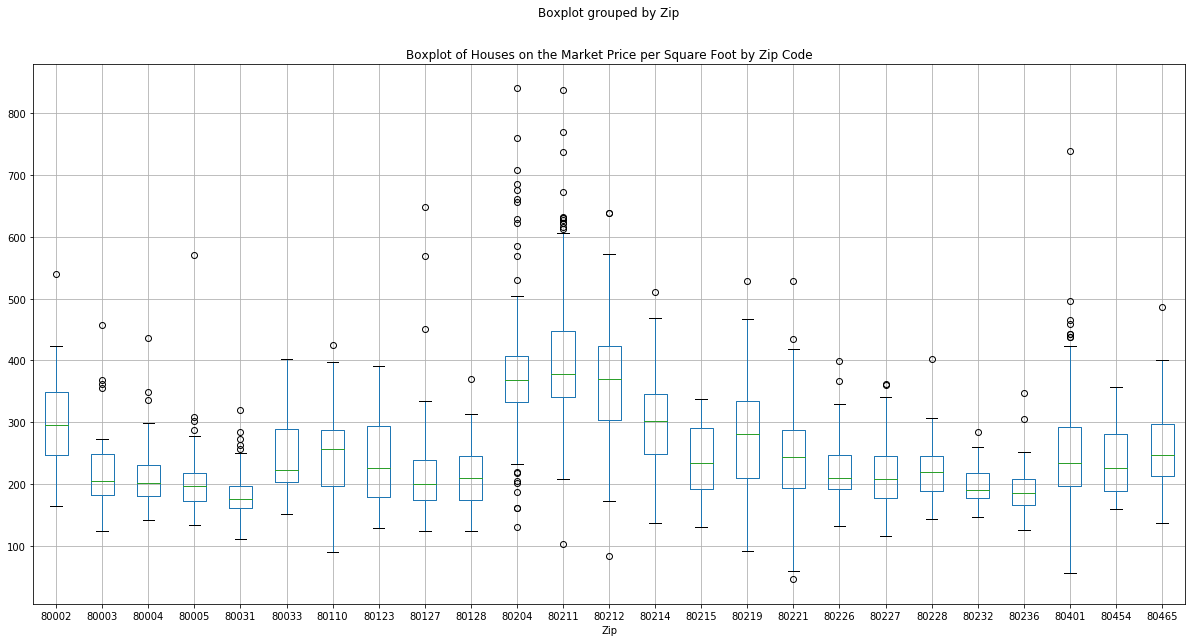

In [20]:
# Create a boxplot to compare means
for_sale_df.boxplot("Price per Square Foot", by="Zip", figsize=(20, 10))
plt.title('Boxplot of Houses on the Market Price per Square Foot by Zip Code')
plt.savefig("../Images/for_sale_boxplot.png")
plt.show()

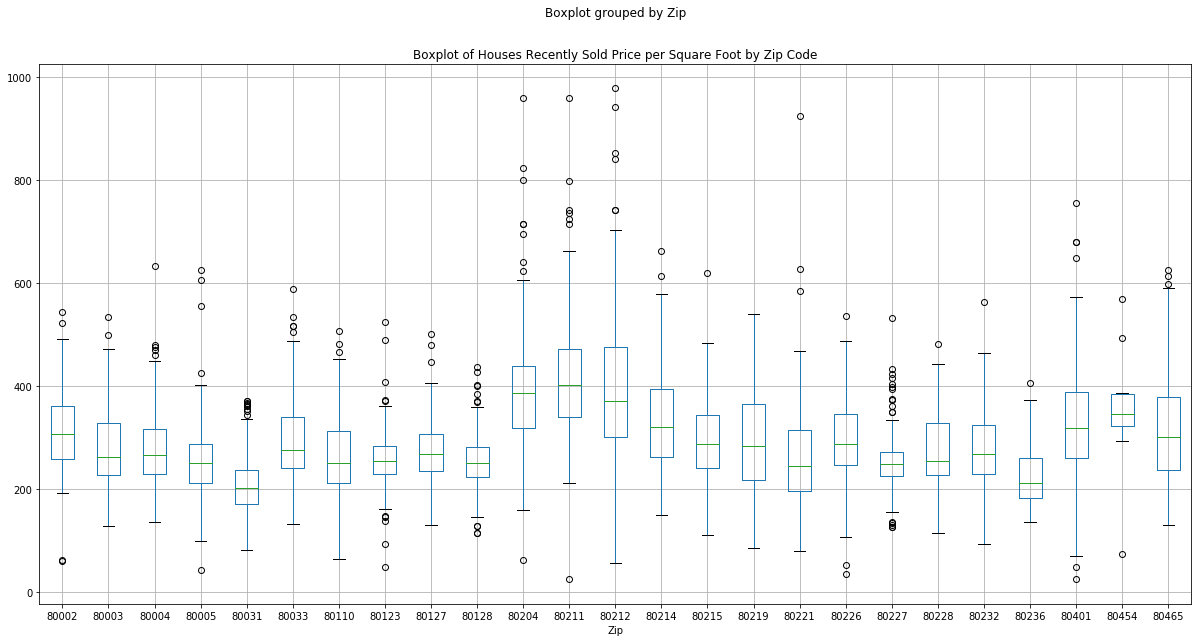

In [21]:
# Create a boxplot to compare means
sold_df.boxplot("Price per Square Foot", by="Zip", figsize=(20, 10))
plt.title('Boxplot of Houses Recently Sold Price per Square Foot by Zip Code')
plt.savefig("../Images/sold_boxplot.png")
plt.show()

In [22]:
for_sale_df['Price per Square Foot'] = for_sale_df['Price per Square Foot'].round(2)
for_sale_grouped = for_sale_df.groupby('Zip')
def stats_avg(x):
    column_names = {
        'Avg Price per Sq Ft': x['Price per Square Foot'].aggregate(np.mean),
        'Average Price': x['Prices'].aggregate(np.mean),
        'Variance': x['Price per Square Foot'].aggregate(np.var),
        'Standard Deviation': x['Price per Square Foot'].aggregate(np.std)}
    return pd.Series(column_names,index=['Average Price','Avg Price per Sq Ft','Variance','Standard Deviation'])
for_sale_summary = for_sale_grouped.apply(stats_avg)
for_sale_summary['SEM'] = for_sale_grouped['Price per Square Foot'].aggregate(st.sem)
for_sale_summary['Average Price']=for_sale_summary['Average Price'].astype(int)
for_sale_summary['Avg Price per Sq Ft']=for_sale_summary['Avg Price per Sq Ft'].round(2)
for_sale_summary['Variance']=for_sale_summary['Variance'].round(2)
for_sale_summary['Standard Deviation']=for_sale_summary['Standard Deviation'].round(2)
for_sale_summary['SEM']=for_sale_summary['SEM'].round(2)
for_sale_summary = for_sale_summary.sort_values('Avg Price per Sq Ft')
for_sale_summary

Average Price  Avg Price per Sq Ft  Variance  Standard Deviation    SEM
Zip                                                                           
80031         401596               184.45   1282.27               35.81   3.88
80236         407180               196.44   2145.46               46.32   8.46
80232         436135               199.79   1022.68               31.98   5.57
80005         538793               205.56   3711.02               60.92   7.18
80004         536617               211.48   2123.44               46.08   4.80
80128         455757               213.86   2365.60               48.64   5.16
80127         635261               214.34   5174.93               71.94   6.74
80227         443290               218.25   2779.01               52.72   6.39
80228         518597               220.45   1949.04               44.15   5.28
80003         404904               221.86   3824.13               61.84   8.83
80226         404807               227.12   3435.62               58.61   8.21
80215         513782               237.97   3062.70               55.34   8.25
80221         436795               238.26   6470.67               80.44   7.06
80123         627354               239.61   4590.12               67.75   6.74
80454         924783               240.93   4359.33               66.03  19.06
80033         507093               246.43   4055.39               63.68   8.43
80110         430454               251.31   4127.64               64.25   7.32
80465         964491               257.71   5112.55               71.50  10.21
80401         989405               262.44  11813.08              108.69  12.31
80219         360944               282.81   7204.06               84.88   8.40
80002         463521               300.24   7465.70               86.40  16.95
80214         424077               302.41   6293.11               79.33   9.69
80212         723279               371.34   7410.68               86.09   7.46
80204         540151               377.56   9620.65               98.08   7.08
80211         676682               399.68  11244.54              106.04   7.67

In [23]:
# Import walkscore dataframe
walkscore_df = pd.read_csv('../Resources/Walkscore.csv')
# merge with for_sale_summary
sale_summary = pd.merge(for_sale_summary, walkscore_df, on="Zip")
sale_summary = sale_summary.drop(columns=['Lat','Lng'])
sale_summary = sale_summary.rename(columns={'walk_score':'Walk Score','walk_description':'Walk Description'})
sale_summary

Zip  Average Price  Avg Price per Sq Ft  Variance  Standard Deviation  \
0   80031         401596               184.45   1282.27               35.81   
1   80236         407180               196.44   2145.46               46.32   
2   80232         436135               199.79   1022.68               31.98   
3   80005         538793               205.56   3711.02               60.92   
4   80004         536617               211.48   2123.44               46.08   
5   80128         455757               213.86   2365.60               48.64   
6   80127         635261               214.34   5174.93               71.94   
7   80227         443290               218.25   2779.01               52.72   
8   80228         518597               220.45   1949.04               44.15   
9   80003         404904               221.86   3824.13               61.84   
10  80226         404807               227.12   3435.62               58.61   
11  80215         513782               237.97   3062.70               55.34   
12  80221         436795               238.26   6470.67               80.44   
13  80123         627354               239.61   4590.12               67.75   
14  80454         924783               240.93   4359.33               66.03   
15  80033         507093               246.43   4055.39               63.68   
16  80110         430454               251.31   4127.64               64.25   
17  80465         964491               257.71   5112.55               71.50   
18  80401         989405               262.44  11813.08              108.69   
19  80219         360944               282.81   7204.06               84.88   
20  80002         463521               300.24   7465.70               86.40   
21  80214         424077               302.41   6293.11               79.33   
22  80212         723279               371.34   7410.68               86.09   
23  80204         540151               377.56   9620.65               98.08   
24  80211         676682               399.68  11244.54              106.04   

      SEM  Walk Score   Walk Description  
0    3.88          15      Car-Dependent  
1    8.46          34      Car-Dependent  
2    5.57          36      Car-Dependent  
3    7.18          10      Car-Dependent  
4    4.80          17      Car-Dependent  
5    5.16          14      Car-Dependent  
6    6.74           6      Car-Dependent  
7    6.39          38      Car-Dependent  
8    5.28           2      Car-Dependent  
9    8.83          42      Car-Dependent  
10   8.21          66  Somewhat Walkable  
11   8.25          54  Somewhat Walkable  
12   7.06          37      Car-Dependent  
13   6.74          20      Car-Dependent  
14  19.06           4      Car-Dependent  
15   8.43          47      Car-Dependent  
16   7.32          58  Somewhat Walkable  
17  10.21          12      Car-Dependent  
18  12.31          38      Car-Dependent  
19   8.40          51  Somewhat Walkable  
20  16.95          70  Somewhat Walkable  
21   9.69          66  Somewhat Walkable  
22   7.46          87      Very Walkable  
23   7.08          68  Somewhat Walkable  
24   7.67          78      Very Walkable

In [24]:
# import restaurant ratings
restaurant_df = pd.read_csv('../Resources/Restaurants.csv')
restaurant_df = restaurant_df.rename(columns={'zip':'Zip'})
restaurants = restaurant_df[['Zip','Average Rating']]
restaurants

Zip  Average Rating
0   80454        4.471429
1   80212        4.431579
2   80204        4.410000
3   80211        4.405000
4   80401        4.245000
5   80465        4.189474
6   80002        4.170000
7   80005        4.125000
8   80110        4.120000
9   80004        4.075000
10  80214        4.055000
11  80219        4.045000
12  80031        4.030000
13  80033        4.005000
14  80123        4.000000
15  80227        3.995000
16  80128        3.980000
17  80003        3.975000
18  80215        3.975000
19  80236        3.975000
20  80228        3.965000
21  80221        3.940000
22  80127        3.936842
23  80226        3.825000
24  80232        3.775000

In [25]:
# merge DFs
sale_summary = pd.merge(sale_summary,restaurants,on='Zip')
sale_summary = sale_summary.rename(columns={'Average Rating':'Avg Restaurant Rating'})
sale_summary

Zip  Average Price  Avg Price per Sq Ft  Variance  Standard Deviation  \
0   80031         401596               184.45   1282.27               35.81   
1   80236         407180               196.44   2145.46               46.32   
2   80232         436135               199.79   1022.68               31.98   
3   80005         538793               205.56   3711.02               60.92   
4   80004         536617               211.48   2123.44               46.08   
5   80128         455757               213.86   2365.60               48.64   
6   80127         635261               214.34   5174.93               71.94   
7   80227         443290               218.25   2779.01               52.72   
8   80228         518597               220.45   1949.04               44.15   
9   80003         404904               221.86   3824.13               61.84   
10  80226         404807               227.12   3435.62               58.61   
11  80215         513782               237.97   3062.70               55.34   
12  80221         436795               238.26   6470.67               80.44   
13  80123         627354               239.61   4590.12               67.75   
14  80454         924783               240.93   4359.33               66.03   
15  80033         507093               246.43   4055.39               63.68   
16  80110         430454               251.31   4127.64               64.25   
17  80465         964491               257.71   5112.55               71.50   
18  80401         989405               262.44  11813.08              108.69   
19  80219         360944               282.81   7204.06               84.88   
20  80002         463521               300.24   7465.70               86.40   
21  80214         424077               302.41   6293.11               79.33   
22  80212         723279               371.34   7410.68               86.09   
23  80204         540151               377.56   9620.65               98.08   
24  80211         676682               399.68  11244.54              106.04   

      SEM  Walk Score   Walk Description  Avg Restaurant Rating  
0    3.88          15      Car-Dependent               4.030000  
1    8.46          34      Car-Dependent               3.975000  
2    5.57          36      Car-Dependent               3.775000  
3    7.18          10      Car-Dependent               4.125000  
4    4.80          17      Car-Dependent               4.075000  
5    5.16          14      Car-Dependent               3.980000  
6    6.74           6      Car-Dependent               3.936842  
7    6.39          38      Car-Dependent               3.995000  
8    5.28           2      Car-Dependent               3.965000  
9    8.83          42      Car-Dependent               3.975000  
10   8.21          66  Somewhat Walkable               3.825000  
11   8.25          54  Somewhat Walkable               3.975000  
12   7.06          37      Car-Dependent               3.940000  
13   6.74          20      Car-Dependent               4.000000  
14  19.06           4      Car-Dependent               4.471429  
15   8.43          47      Car-Dependent               4.005000  
16   7.32          58  Somewhat Walkable               4.120000  
17  10.21          12      Car-Dependent               4.189474  
18  12.31          38      Car-Dependent               4.245000  
19   8.40          51  Somewhat Walkable               4.045000  
20  16.95          70  Somewhat Walkable               4.170000  
21   9.69          66  Somewhat Walkable               4.055000  
22   7.46          87      Very Walkable               4.431579  
23   7.08          68  Somewhat Walkable               4.410000  
24   7.67          78      Very Walkable               4.405000

In [26]:
# create a formula based on values in summary dataframe
# formula will include weighting of variables and can then have the highest value be the "best" zip code
# Mark Rating = Avg price/sq ft * APSF_wt + Variance * Var_wt + Walkscore * WS_wt + Avg Rest Rating * ARR_wt + Crimescore * CS_wt
apsf_wt = 1
var_wt = 2.5
ws_wt = 0.5
arr_wt = 0.2
cs_wt = 'unkown right now'
# factors are to get the data within the same range
# average price per square foot is negative because we want the lowest value
apsf_factor = -1
var_factor = 0.01
ws_factor = 5
arr_factor = 100
cs_factor = 'unknown right now'


In [27]:
# set up the new dataframe with factors and weights
mark_df = sale_summary [['Zip','Avg Price per Sq Ft','Variance','Walk Score','Avg Restaurant Rating']]
APSF = []
Var = []
WS = []
ARR = []
Score = []
for i in range (0,25):
    APSF.append(mark_df.iloc[i,1]*apsf_wt*apsf_factor)
    Var.append(mark_df.iloc[i,2]*var_wt*var_factor)
    WS.append(mark_df.iloc[i,3]*ws_wt*ws_factor)
    ARR.append(mark_df.iloc[i,4]*arr_wt*arr_factor)
    Score.append(APSF[i]+Var[i]+WS[i]+ARR[i])
mark_df['Mark Score'] = Score
mark_df

C:\Users\ngoodwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Zip  Avg Price per Sq Ft  Variance  Walk Score  Avg Restaurant Rating  \
0   80031               184.45   1282.27          15               4.030000   
1   80236               196.44   2145.46          34               3.975000   
2   80232               199.79   1022.68          36               3.775000   
3   80005               205.56   3711.02          10               4.125000   
4   80004               211.48   2123.44          17               4.075000   
5   80128               213.86   2365.60          14               3.980000   
6   80127               214.34   5174.93           6               3.936842   
7   80227               218.25   2779.01          38               3.995000   
8   80228               220.45   1949.04           2               3.965000   
9   80003               221.86   3824.13          42               3.975000   
10  80226               227.12   3435.62          66               3.825000   
11  80215               237.97   3062.70          54               3.975000   
12  80221               238.26   6470.67          37               3.940000   
13  80123               239.61   4590.12          20               4.000000   
14  80454               240.93   4359.33           4               4.471429   
15  80033               246.43   4055.39          47               4.005000   
16  80110               251.31   4127.64          58               4.120000   
17  80465               257.71   5112.55          12               4.189474   
18  80401               262.44  11813.08          38               4.245000   
19  80219               282.81   7204.06          51               4.045000   
20  80002               300.24   7465.70          70               4.170000   
21  80214               302.41   6293.11          66               4.055000   
22  80212               371.34   7410.68          87               4.431579   
23  80204               377.56   9620.65          68               4.410000   
24  80211               399.68  11244.54          78               4.405000   

    Mark Score  
0   -34.293250  
1    21.696500  
2    -8.723000  
3    -5.284500  
4   -34.394000  
5   -40.120000  
6     8.770092  
7    26.125250  
8   -87.424000  
9    58.243250  
10  100.270500  
11   53.097500  
12   94.806750  
13    5.143000  
14  -32.518179  
15   52.554750  
16   79.281000  
17  -16.106776  
18  212.787000  
19  105.691500  
20  144.802500  
21  101.017750  
22  120.058579  
23  121.156250  
24  164.533500

In [28]:
# cleanup of values
mark_score = mark_df.sort_values('Mark Score', ascending=False)
mark_score['Avg Restaurant Rating'] = mark_score['Avg Restaurant Rating'].round(2)
mark_score['Mark Score'] = mark_score['Mark Score'].round(2)
mark_score

Zip  Avg Price per Sq Ft  Variance  Walk Score  Avg Restaurant Rating  \
18  80401               262.44  11813.08          38                   4.24   
24  80211               399.68  11244.54          78                   4.40   
20  80002               300.24   7465.70          70                   4.17   
23  80204               377.56   9620.65          68                   4.41   
22  80212               371.34   7410.68          87                   4.43   
19  80219               282.81   7204.06          51                   4.04   
21  80214               302.41   6293.11          66                   4.06   
10  80226               227.12   3435.62          66                   3.82   
12  80221               238.26   6470.67          37                   3.94   
16  80110               251.31   4127.64          58                   4.12   
9   80003               221.86   3824.13          42                   3.98   
11  80215               237.97   3062.70          54                   3.98   
15  80033               246.43   4055.39          47                   4.00   
7   80227               218.25   2779.01          38                   4.00   
1   80236               196.44   2145.46          34                   3.97   
6   80127               214.34   5174.93           6                   3.94   
13  80123               239.61   4590.12          20                   4.00   
3   80005               205.56   3711.02          10                   4.13   
2   80232               199.79   1022.68          36                   3.78   
17  80465               257.71   5112.55          12                   4.19   
14  80454               240.93   4359.33           4                   4.47   
0   80031               184.45   1282.27          15                   4.03   
4   80004               211.48   2123.44          17                   4.08   
5   80128               213.86   2365.60          14                   3.98   
8   80228               220.45   1949.04           2                   3.97   

    Mark Score  
18      212.79  
24      164.53  
20      144.80  
23      121.16  
22      120.06  
19      105.69  
21      101.02  
10      100.27  
12       94.81  
16       79.28  
9        58.24  
11       53.10  
15       52.55  
7        26.13  
1        21.70  
6         8.77  
13        5.14  
3        -5.28  
2        -8.72  
17      -16.11  
14      -32.52  
0       -34.29  
4       -34.39  
5       -40.12  
8       -87.42

In [29]:
# Add lat/lng to DF
locations_df = pd.read_csv('../Resources/zip_lat_lng.csv')
locations_df.columns = ['remove','Zip','lat','lng']
mark_score_loc = pd.merge(locations_df,mark_score,on='Zip')

In [30]:
# cleaning dataframe of unnecessary data and removing negative scores as gmaps cant do a heat of negative 
mark_score_loc = mark_score_loc.drop(columns=['remove','Avg Price per Sq Ft','Variance','Walk Score','Avg Restaurant Rating'])

In [31]:
mark_score_loc = mark_score_loc.sort_values('Mark Score').reset_index(drop=True)
mark_score_loc = mark_score_loc.drop(index=[0,1,2,3,4,5,6,7])

In [32]:
mark_score_loc.to_csv('../Resources/mark_score_loc.csv')

In [113]:
# import final Mark Scores from crime data integration
mark_score_final = pd.read_csv('../Resources/mark_score_final.csv')
finalzip = [80401,80211,80002,80204,80212]
# get the rest of the scores into a dataframe
mark_score_values = mark_df[['Zip','Mark Score']]
mark_score_values['Price Score'] = APSF
mark_score_values['Variance Score'] = Var
mark_score_values['Walk Score'] = WS
mark_score_values['Restaurant Score'] = ARR
mark_score_values = mark_score_values.loc[mark_score_values["Zip"].isin(finalzip)].reset_index(drop=True)
mark_score_values = mark_score_values.rename(columns={'Zip':'Zip Code'})
mark_score_values

C:\Users\ngoodwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ngoodwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\ngoodwei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Zip Code  Mark Score  Price Score  Variance Score  Walk Score  \
0     80401  212.787000      -262.44       295.32700        95.0   
1     80002  144.802500      -300.24       186.64250       175.0   
2     80212  120.058579      -371.34       185.26700       217.5   
3     80204  121.156250      -377.56       240.51625       170.0   
4     80211  164.533500      -399.68       281.11350       195.0   

   Restaurant Score  
0         84.900000  
1         83.400000  
2         88.631579  
3         88.200000  
4         88.100000

In [114]:
# merge dataframes for all scores
mark_score_final = pd.merge(mark_score_values,mark_score_final,on='Zip Code')

In [115]:
# cleaning up and formatting the dataframe
mark_score_final = mark_score_final[['Zip Code','Price Score','Variance Score','Walk Score','Restaurant Score','Crime Score','Mark Score','Final Mark Score']]
mark_score_final = mark_score_final.rename(columns={'Mark Score':'Price/Var/Walk/Rest Score'})


In [116]:
mark_score_final = mark_score_final.sort_values('Final Mark Score',ascending=False).reset_index(drop=True)
mark_score_final

Zip Code  Price Score  Variance Score  Walk Score  Restaurant Score  \
0     80401      -262.44       295.32700        95.0         84.900000   
1     80002      -300.24       186.64250       175.0         83.400000   
2     80211      -399.68       281.11350       195.0         88.100000   
3     80212      -371.34       185.26700       217.5         88.631579   
4     80204      -377.56       240.51625       170.0         88.200000   

   Crime Score  Price/Var/Walk/Rest Score  Final Mark Score  
0       -1.125                 212.787000           211.665  
1       -0.000                 144.802500           144.800  
2      -37.200                 164.533500           127.330  
3      -31.575                 120.058579            88.485  
4      -41.775                 121.156250            79.385

In [117]:
# .applymap for multiple columns, .map for single column 
mark_score_final[['Price Score','Variance Score','Walk Score','Restaurant Score','Price/Var/Walk/Rest Score','Final Mark Score']] = mark_score_final[['Price Score','Variance Score','Walk Score','Restaurant Score','Price/Var/Walk/Rest Score','Final Mark Score']].applymap('{:.0f}'.format)
mark_score_final['Crime Score'] = mark_score_final['Crime Score'].map('{:.1f}'.format)
mark_score_final

Zip Code Price Score Variance Score Walk Score Restaurant Score  \
0     80401        -262            295         95               85   
1     80002        -300            187        175               83   
2     80211        -400            281        195               88   
3     80212        -371            185        218               89   
4     80204        -378            241        170               88   

  Crime Score Price/Var/Walk/Rest Score Final Mark Score  
0        -1.1                       213              212  
1        -0.0                       145              145  
2       -37.2                       165              127  
3       -31.6                       120               88  
4       -41.8                       121               79

In [118]:
mark_score_final.to_csv('../Resources/final_summary.csv')